In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
import matplotlib as mpl

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from qiskit_nature.drivers import PySCFDriver
molecule = "H .0 .0 .0; H .0 .0 0.739"
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

/tmp/ipykernel_394/1640696031.py:3: DeprecationWarning: The PySCFDriver class is deprecated as of version 0.2.0 and will be removed no sooner than 3 months after the release. Instead use the PySCFDriver class from qiskit_nature.drivers.second_quantization.pyscfd.
  driver = PySCFDriver(atom=molecule)


In [3]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
problem = ElectronicStructureProblem(driver)
second_q_ops = problem.second_q_ops()
main_op = second_q_ops[0]

In [4]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
mapper = JordanWignerMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=False)
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

/tmp/ipykernel_394/962686619.py:5: DeprecationWarning: The molecule_data_transformed property is deprecated as of version 0.2.0 and will be removed no sooner than 3 months after the release. Instead use the grouped_property_transformed property.
  num_particles = (problem.molecule_data_transformed.num_alpha,


#### Initial State
We will start by considering $\psi = |0101\rangle$ as the initial state.

In [5]:
from qiskit_nature.circuit.library import HartreeFock
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

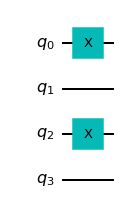

In [6]:
init_state.draw('mpl')

#### Ansatz
We will use two-local ansatz as the default ansatz for this problem as it is readily available in the qiskit library and easy to compose.

In [7]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
rotation_blocks = ['ry', 'rz']
entanglement_blocks = 'cx' 
entanglement = 'full'
repetitions = 3
skip_final_rotation_layer = True
ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                  entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
# adding the initial state
ansatz.compose(init_state, front=True, inplace=True)

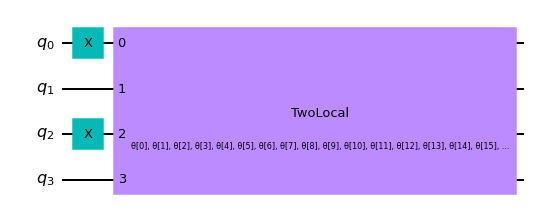

In [8]:
ansatz.draw('mpl')

In [9]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

In [10]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
optimizer = COBYLA(maxiter=500)

#### Exact Energy
Here I've shown some results for our chosen molecule, which are the exact values for different parameters of the molecule.

In [11]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

Exact electronic energy -1.8533636186720357
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.853363618672
  - computed part:      -1.853363618672
~ Nuclear repulsion energy (Hartree): 0.716072003951
> Total ground state energy (Hartree): -1.137291614721
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.39650761]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.39650761]
    - computed part:      [0.0  0.0  1.39650761]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.00000001]  Total: 0.00000001
 


#### Calculating Energy for $H_2$ using VQE and finding errors in our calculation.

In [12]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std): 
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 500,
    'eigenstate': array([-8.01967738e-06+5.35021714e-05j,  6.78005082e-06+9.49056742e-05j,
        8.56961045e-06-1.44705532e-05j,  7.77754647e-05-4.74281620e-05j,
        1.57195558e-06-3.49200780e-07j,  9.48583307e-01+2.95900636e-01j,
        1.04027944e-03-1.80342805e-03j,  7.63572001e-08-1.42746754e-07j,
        1.86016557e-09+4.59114937e-08j, -9.39806181e-04+1.22919986e-03j,
       -1.07258614e-01-3.34862821e-02j, -1.36549702e-05-4.21335684e-06j,
       -8.40583917e-06+5.30799761e-06j, -7.70667653e-05+1.24317568e-04j,
       -9.80019416e-06-3.76518704e-06j, -1.00450272e-04-2.76953620e-05j]),
    'eigenvalue': (-1.85335941174982+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[18]): 0.026260747676010623,
                              ParameterVectorElement(θ[17]): 3.1414137352538263,
                              ParameterVectorElement(θ[16]): 0.003925607256799522,
                              Paramet

In [13]:
#calculating percentage error
E_th = -1.8533636186720357
E_vqe = -1.85335941174982

print("The percentage error in our calculation is " + str(np.abs(E_th-E_vqe)/E_th *100)+" %")

The percentage error in our calculation is -0.00022698849666174086 %
